This notebook downloads a small piece of a text dataset to local cache (`/Users/USER/.cache/huggingface/datasets` on macbook). Then, you should manually install the files (which are dicts for activations and locations for each feature) from [https://huggingface.co/datasets/MrGonao/raw_features_gemma16/tree/main](https://huggingface.co/datasets/MrGonao/raw_features_gemma16/tree/main) to the features folder. After doing this, the code below will find you the activating documents for each feature. 

In [1]:
from graphs import load_tokens, load_activations
all_tokens, tokenizer = load_tokens("google/gemma-2-9B", "kh4dien/fineweb-100m-sample")
activations, locations = load_activations('features/11_0_3275.safetensors')

/Users/eriq/Desktop/syntax-sae/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
torch.save(all_tokens, 'all_tokens.pt')

In [3]:
all_tokens.shape

torch.Size([401777, 256])

In [4]:
tokenizer

GemmaTokenizerFast(name_or_path='google/gemma-2-9B', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<eos>', 'additional_special_tokens': ['<start_of_turn>', '<end_of_turn>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	5: AddedToken("<2mass>", rstrip=False, lstrip=False, single_wo

In [2]:
import spacy
spacy.symbols.IDS

{'': 0,
 'IS_ALPHA': 1,
 'IS_ASCII': 2,
 'IS_DIGIT': 3,
 'IS_LOWER': 4,
 'IS_PUNCT': 5,
 'IS_SPACE': 6,
 'IS_TITLE': 7,
 'IS_UPPER': 8,
 'LIKE_URL': 9,
 'LIKE_NUM': 10,
 'LIKE_EMAIL': 11,
 'IS_STOP': 12,
 'IS_OOV_DEPRECATED': 13,
 'IS_BRACKET': 14,
 'IS_QUOTE': 15,
 'IS_LEFT_PUNCT': 16,
 'IS_RIGHT_PUNCT': 17,
 'IS_CURRENCY': 18,
 'FLAG19': 19,
 'FLAG20': 20,
 'FLAG21': 21,
 'FLAG22': 22,
 'FLAG23': 23,
 'FLAG24': 24,
 'FLAG25': 25,
 'FLAG26': 26,
 'FLAG27': 27,
 'FLAG28': 28,
 'FLAG29': 29,
 'FLAG30': 30,
 'FLAG31': 31,
 'FLAG32': 32,
 'FLAG33': 33,
 'FLAG34': 34,
 'FLAG35': 35,
 'FLAG36': 36,
 'FLAG37': 37,
 'FLAG38': 38,
 'FLAG39': 39,
 'FLAG40': 40,
 'FLAG41': 41,
 'FLAG42': 42,
 'FLAG43': 43,
 'FLAG44': 44,
 'FLAG45': 45,
 'FLAG46': 46,
 'FLAG47': 47,
 'FLAG48': 48,
 'FLAG49': 49,
 'FLAG50': 50,
 'FLAG51': 51,
 'FLAG52': 52,
 'FLAG53': 53,
 'FLAG54': 54,
 'FLAG55': 55,
 'FLAG56': 56,
 'FLAG57': 57,
 'FLAG58': 58,
 'FLAG59': 59,
 'FLAG60': 60,
 'FLAG61': 61,
 'FLAG62': 62,
 'FLAG63'

In [4]:
k = { 'ADJ': 84,
 'ADP': 85,
 'ADV': 86,
 'AUX': 87,
 'CONJ': 88,
 'CCONJ': 89,
 'DET': 90,
 'INTJ': 91,
 'NOUN': 92,
 'NUM': 93,
 'PART': 94,
 'PRON': 95,
 'PROPN': 96,
 'PUNCT': 97,
 'SCONJ': 98,
 'SYM': 99,
 'VERB': 100,
 'X': 101}

k = dict((v,k) for k,v in k.items())
k

{84: 'ADJ',
 85: 'ADP',
 86: 'ADV',
 87: 'AUX',
 88: 'CONJ',
 89: 'CCONJ',
 90: 'DET',
 91: 'INTJ',
 92: 'NOUN',
 93: 'NUM',
 94: 'PART',
 95: 'PRON',
 96: 'PROPN',
 97: 'PUNCT',
 98: 'SCONJ',
 99: 'SYM',
 100: 'VERB',
 101: 'X'}

In [5]:
### Get Contexts and View Batch
import torch
#get context
def get_context(batch: list[str], pos: int, n=5) -> str:
    context = ''.join([s for s in batch[pos-n:pos+n] if s != '\n'])
    return context

def view_batch(n: int, tokenizer) -> list[str]:
    if n >= len(all_tokens):
        return None
    doc = all_tokens[n]
    return tokenizer.batch_decode(doc)

In [7]:
from itertools import accumulate
def positions_to_char_indices(context: list[str], token_positions: list[int]) -> list[int]:
    # Concatenate all context strings to form a single string
    char_indices = [0] + list(accumulate(len(s) for s in context))
    character_positions = [char_indices[position] for position in token_positions]
    return character_positions

context = ["I like to", "like", "rock", "climbing"]
positions = [0,1,2,3]
char_pos = positions_to_char_indices(context, positions)
char_pos

[0, 9, 13, 17]

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_parse_tree(parse_dict):
    G = nx.DiGraph()
    for token in parse_dict:
        G.add_node(token['text'])
        for child in token['children']:
            G.add_edge(token['text'], child)
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  # You can also try 'shell_layout', 'circular_layout', etc.
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2000, font_size=12, font_weight="bold")
    plt.show()

### Make and Visualize Parse Trees with Spacy

In [8]:
def ttnp(tensor):
    return tensor.detach().cpu().item()

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [10]:
import importlib
import graphs
importlib.reload(graphs)

<module 'graphs' from '/Users/eriq/Desktop/syntax-sae/graphs.py'>

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import graphs 
from graphs import make_parse_tree
import numpy as np

def batch_dicts(n, activations, locations, k=5):
    print(f"Visualizing Feature {n}")
    idx = locations[:,2]== n #batches where feature is 2400
    locations = locations[idx]
    activations = activations[idx]
    #location dicts is by batch, containing position-activation pairs.
    total_batches = 39039
    batch_dicts = [{'positions': [], 'activations': []} for i in range(0, total_batches + 1)]

    for location, activation in zip(locations, activations):
        d = batch_dicts[location[0]]
        d['positions'].append(int(ttnp(location[1])))
        d['activations'].append(activation)

    batch_max_activations = []

    # Iterate through each batch and find the maximum activation and its position
    for batch_index in range(total_batches):
        if batch_dicts[batch_index]['activations']:  # Check if there are any activations in the batch
            max_activation = max(batch_dicts[batch_index]['activations'])
            max_position = batch_dicts[batch_index]['positions'][batch_dicts[batch_index]['activations'].index(max_activation)]
            batch_max_activations.append((batch_index, max_activation, max_position))

    sorted_max_activations = sorted(batch_max_activations, key=lambda x: x[1], reverse=True)
    top_batches = sorted_max_activations[:k]
    return top_batches

In [50]:
def batch_dicts(n, activations, locations, k=5):
    idx = locations[:,2]== n 
    locations = locations[idx]
    activations = activations[idx]
    total_batches = 39039
    batch_dicts = [{'positions': [], 'activations': []} for i in range(0, total_batches + 1)]

    for location, activation in zip(locations, activations):
        d = batch_dicts[location[0]]
        d['positions'].append(int(ttnp(location[1])))
        d['activations'].append(activation)
    
    batchdict_tuple = [(d, max(d['activations']) if d['activations'] else float('-inf')) for d in batch_dicts]
    sorted_tuples = sorted(batchdict_tuple, key=lambda x: x[1], reverse=True)[:5]
    top_n_dicts = [d for d, _ in sorted_tuples[:n]]
    return top_n_dicts

top_dicts = batch_dicts(2400, activations, locations, 5)
top_dicts

[{'positions': [93, 94, 95, 96, 97, 98, 99, 100, 101, 215],
  'activations': [np.float16(5.414),
   np.float16(8.414),
   np.float16(8.84),
   np.float16(43.5),
   np.float16(16.53),
   np.float16(27.47),
   np.float16(16.11),
   np.float16(15.78),
   np.float16(22.64),
   np.float16(5.203)]},
 {'positions': [113,
   116,
   117,
   118,
   119,
   121,
   122,
   125,
   126,
   132,
   163,
   164,
   165,
   166,
   169,
   170,
   175,
   180,
   188],
  'activations': [np.float16(6.67),
   np.float16(12.22),
   np.float16(41.4),
   np.float16(20.78),
   np.float16(13.69),
   np.float16(14.445),
   np.float16(5.8),
   np.float16(14.016),
   np.float16(5.453),
   np.float16(5.535),
   np.float16(4.64),
   np.float16(21.45),
   np.float16(19.3),
   np.float16(5.99),
   np.float16(4.71),
   np.float16(8.516),
   np.float16(9.33),
   np.float16(7.117),
   np.float16(7.57)]},
 {'positions': [106,
   149,
   150,
   151,
   152,
   154,
   155,
   156,
   157,
   158,
   159,
   160,
   

In [7]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("This is a sentence.")

for token in doc:
    print(token.text, len(token))

This 4
is 2
a 1
sentence 8
. 1


In [9]:
!pip list

Package            Version
------------------ -----------
accelerate         1.0.1
aiohappyeyeballs   2.4.3
aiohttp            3.10.10
aiosignal          1.3.1
annotated-types    0.7.0
appnope            0.1.4
asttokens          2.4.1
attrs              24.2.0
beartype           0.14.1
better-abc         0.0.3
bidict             0.23.1
blinker            1.8.2
blis               1.0.1
catalogue          2.0.10
certifi            2024.8.30
charset-normalizer 3.4.0
click              8.1.7
cloudpathlib       0.20.0
comm               0.2.2
confection         0.1.5
contourpy          1.3.0
cycler             0.12.1
cymem              2.0.8
datasets           3.0.2
debugpy            1.8.7
decorator          5.1.1
diffusers          0.31.0
dill               0.3.8
docker-pycreds     0.4.0
einops             0.8.0
en_core_web_sm     3.8.0
executing          2.1.0
fancy-einsum       0.0.3
filelock           3.16.1
Flask              3.0.3
fonttools          4.54.1
frozenlist         1.5.0
fs

In [8]:
len('It makes my drive back to Chicago go a lot faster.')

50

In [4]:
from itertools import accumulate

def positions_to_char_indices(context: list[str], positions: list[int]):
    # Concatenate all context strings to form a single string
    context_str = "".join(context)
    char_indices = list(accumulate(len(s) for s in context)) #[1, 5, 9, 17]
    character_positions = [char_indices[position] for position in positions]
    return character_positions, context_str

context = ["I", "like", "rock", "climbing"]
positions = [0, 2]
char_pos, _ = positions_to_char_indices(context, positions)
assert(char_pos == [1,9])

In [10]:
len('If you’re looking for a luxe investment, then look to Equipment for the best in upmarket basics.')

96

In [13]:
def get_token_idx(string_list: list[str], char_index: int):
    # Concatenate the list of strings into a single string
    current_length = 0
    for i, s in enumerate(string_list):
        current_length += len(s)
        if current_length > char_index:
            return i  
    raise Exception("Char index not found in List")

context = ["I", "like", "rock", "climbing"]
pos1 = 4
pos2 = 8
assert(get_token_idx(context, pos1) == 1)
assert(get_token_idx(context, pos2) == 2)

In [5]:
import spacy
def get_sentence_at_index(doc, char_index):
    for sent in doc.sents:
        if sent.start_char <= char_index < sent.end_char:
            start_char = sent.start_char
            return sent.text, sent.start_char
    raise Exception("No sentence at index")

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("sentencizer")


In [7]:
batch = '''<bos>Once you’ve got some momentum, you’re going to need to design some packaging materials and point of sale purchase offerings and come up with a great story to tell your loyal customers. And that’s where your marketing partner can help the most. By keeping your story consistently in front of your best customers instead of a “spray and pray” approach you can save a ton of money.
We believe in helping restaurant marketing directors save money through smart marketing.
Download this FREE Fill-in-the-Blanks Worksheeet today!What's the difference between LC 'shell' and OSX terminal?
andre at andregarzia.com
Fri Oct 28 15:09:34 CDT 2011
This is probably a PATH issue. See when you launch your terminal, a bash
script is executed. You can think of this script as the code in
preOpenTerminal. Among other things, this script will set the PATH variable
which holds a list of folders to look for commands in. So when you use the
"convert" command, bash (which is the shell you are using in your terminal)
will look inside those folders for a convert command. When you execute
shell()'''

batch[1083]

IndexError: string index out of range

In [27]:
batch = ['Resort', '-', 'like', 'outdoor', 'entertainment', 'area', 'includes', 'a', 'custom', 'pebble', 'pool', 'and', 'spa', 'with', 'waterfall', ',', 'built', '-', 'in', 'bbq', 'and', 'even', 'a', 'wood', '-', 'fired', 'pizza', 'oven', '.']
batch[23]

'wood'

In [30]:
batches = [' How', ' To', ' Utilize', ' Casino', ' To', ' Wish', '\n', 'Before', ' releasing', ' your', ' publication', ' or', ' your', ' gambling', ' internet', ' site', ',', ' you', ' require', ' to', ' have', ' your', ' editors', ' check', ' it', ' out', ',', ' reviewed', ' the', ' components', ',', ' and', ' also', ' discuss', ' points', ' that', ' have', ' actually', ' to', ' be', ' boosted', ' or', ' recommend', ' far', ' better', ' layouts', ' if', ' required']
batches[47]

' required'

In [26]:
from spacy.tokens import Token
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("sentencizer")
Token.set_extension("custom_tag", default=0, force=True)

def positions_to_char_indices(context: list[str], token_positions: list[int]) -> list[int]:
    # Concatenate all context strings to form a single string
    char_indices = list(accumulate(len(s) for s in context))
    character_positions = [char_indices[position] for position in token_positions]
    print(character_positions)
    return character_positions

def make_parse_tree(context: list[str], positions: list, activations: list):
    #turn tok indices into character indices
    #could we just use the character highlight here?
    #context = "".join(context)
    print(f'[MAKE_PARSE] context is {context} positions are {positions}')
    print(len(context))
    print([context[position] for position in positions])
    character_positions = positions_to_char_indices(context, positions)
    context = "".join(context)
    doc = nlp(context)
    #Set character indices at various activations to value.
    for pos, act in zip(character_positions, activations):
        #print(f'{pos=} {act=} {len(doc[0])}')
        activation_node = None
        for token in doc:
            if (int(token.idx) <= pos <= int(token.idx + len(token))):
                #print(f'{token.idx} {pos} {token.idx+len(token)}')
                
                activation_node = token
        activation_node._.custom_tag = act
    # Find the root node (the one with dep_ == "ROOT")
    root_node = next(node for node in list(doc)[::-1] if node.dep_ == "ROOT")
    return root_node

context = [' presentation', ' -', ' da', 'wood', ' flour', ' mill', ' amp', ' provision', ' p', 'te', ' ltd', '.', ' manufacturer', ',', ' importer', ' and', ' exporter', ' of', ' a', ' wide', ' range', ' of', ' spice', ' powders', ',', ' curry', ' powder', ',', ' wheat', ',', ' rice', ',', ' barley', ',', ' coriander', ',', ' chilli', ',', ' cinnamon', ',', ' mustard', ' seed', ' etc', '.', ' eg', '.', 'meat', ' curry', ' powder', ',', ' fish', ' curry', ' powder', ',', ' t', 'umeric', ' powder', ',', ' sat', 'ay', ' powder', ',', ' coarse', ' black', ' pepper', ',', ' corri', 'ander', ' powder', ' etc', '.', '\n', 'main', ' features', ' of', ' the', ' wood', ' flour', ' mill', ' grinder']
filtered_positions = (3, 76, 77)
filtered_activations = (19.390625, 57.40625, 6.29296875, 51.96875, 45.875)
k = make_parse_tree(context, filtered_positions, filtered_activations)

def node_to_dict(token):
    return {
        "text": token.text,
        "lemma": token.lemma_,
        "pos": token.pos_,
        "dep": token.dep_,
        "tag": float(token._.custom_tag),
        "children": [node_to_dict(child) for child in token.children]  # Recursively add children
    }
node_to_dict(k)

[MAKE_PARSE] context is [' presentation', ' -', ' da', 'wood', ' flour', ' mill', ' amp', ' provision', ' p', 'te', ' ltd', '.', ' manufacturer', ',', ' importer', ' and', ' exporter', ' of', ' a', ' wide', ' range', ' of', ' spice', ' powders', ',', ' curry', ' powder', ',', ' wheat', ',', ' rice', ',', ' barley', ',', ' coriander', ',', ' chilli', ',', ' cinnamon', ',', ' mustard', ' seed', ' etc', '.', ' eg', '.', 'meat', ' curry', ' powder', ',', ' fish', ' curry', ' powder', ',', ' t', 'umeric', ' powder', ',', ' sat', 'ay', ' powder', ',', ' coarse', ' black', ' pepper', ',', ' corri', 'ander', ' powder', ' etc', '.', '\n', 'main', ' features', ' of', ' the', ' wood', ' flour', ' mill', ' grinder'] positions are (3, 76, 77)
80
['wood', ' wood', ' flour']
[22, 349, 355]
setting dawood to 19.390625
setting wood to 57.40625
setting flour to 6.29296875


{'text': 'manufacturer',
 'lemma': 'manufacturer',
 'pos': 'NOUN',
 'dep': 'ROOT',
 'tag': 0.0,
 'children': [{'text': 'pte',
   'lemma': 'pte',
   'pos': 'PROPN',
   'dep': 'compound',
   'tag': 0.0,
   'children': [{'text': 'provision',
     'lemma': 'provision',
     'pos': 'PROPN',
     'dep': 'compound',
     'tag': 0.0,
     'children': [{'text': 'dawood',
       'lemma': 'dawood',
       'pos': 'ADJ',
       'dep': 'amod',
       'tag': 19.390625,
       'children': [{'text': 'presentation',
         'lemma': 'presentation',
         'pos': 'NOUN',
         'dep': 'npadvmod',
         'tag': 0.0,
         'children': [{'text': ' ',
           'lemma': ' ',
           'pos': 'SPACE',
           'dep': 'dep',
           'tag': 0.0,
           'children': []}]},
        {'text': '-',
         'lemma': '-',
         'pos': 'PUNCT',
         'dep': 'punct',
         'tag': 0.0,
         'children': []}]},
      {'text': 'amp',
       'lemma': 'amp',
       'pos': 'NOUN',
       'dep'

In [8]:
from itertools import accumulate

def position_to_char_indice(context: list[str], position: int) -> int:
    char_indices = list(accumulate(len(s) for s in context))
    character_position = char_indices[position]
    return character_position

max_token_idx = 255
batch = ['<bos>', ' (', 'see', ' zones', '(', '5', ')),', ' a', ' package', ' that', ' contains', ' a', ' request', ' script', ' (', 'see', ' pkg', 'ask', '(', '1', 'M', '))', ' is', ' added', ' only', ' to', ' the', '\n', 'global', ' zone', '.', ' The', ' package', ' is', ' not', ' propagated', ' to', ' any', ' current', ' or', ' yet', '-', 'to', '-', 'be', '-', 'installed', ' non', '-', 'global', ' zone', '.', ' This', ' behavior', ' mimics', ' the', ' effect', ' of', ' the', ' -', 'G', '\n', 'option', ',', ' described', ' below', '.', '\n', 'The', ' following', ' options', ' are', ' supported', ':', '\n', '-', 'a', ' admin', ' Define', ' an', ' installation', ' administration', ' file', ',', ' admin', ',', ' to', ' be', ' used', ' in', ' place', ' of', ' the', ' default', ' administration', ' file', '.', ' The', ' token', ' none', '\n', 'overrides', ' the', ' use', ' of', ' any', ' admin', ' file', ',', ' and', ' thus', ' forces', ' interaction', ' with', ' the', ' user', '.', ' Unless', ' a', ' full', ' path', ' name', ' is', ' given', ',', ' pkg', 'add', '\n', 'first', ' looks', ' in', ' the', ' current', ' working', ' directory', ' for', ' the', ' administration', ' file', '.', ' If', ' the', ' specified', ' administration', ' file', ' is', ' not', ' in', '\n', 'the', ' current', ' working', ' directory', ',', ' pkg', 'add', ' looks', ' in', ' the', ' /', 'var', '/', 'sad', 'm', '/', 'install', '/', 'admin', ' directory', ' for', ' the', ' administration', ' file', '.', '\n', '-', 'd', ' device', ' Install', ' or', ' copy', ' a', ' package', ' from', ' device', '.', ' device', ' can', ' be', ' a', ' full', ' path', ' name', ' to', ' a', ' directory', ' or', ' the', ' identifiers', ' for', ' tape', ',', ' floppy', '\n', 'disk', ',', ' or', ' removable', ' disk', ' (', 'for', ' example', ',', ' /', 'var', '/', 'tmp', ' or', ' /', 'flo', 'ppy', '/', 'flo', 'ppy', '_', 'name', ' ).', ' It', ' can', ' also', ' be', ' a', ' device', ' alias', ' (', 'for', ' example', ',', '\n', '/', 'flo', 'ppy', '/', 'flo', 'ppy', '0', ')', ' or', ' a', ' data', 'stream', ' created', ' by', ' pkg', 'trans', ' (']
context = '<bos> (see zones(5)), a package that contains a request script (see pkgask(1M)) is added only to the\nglobal zone.'
z
max_char_idx = position_to_char_indice(batch, max_token_idx)
max_char_idx

1092

Visualizing Feature 2400


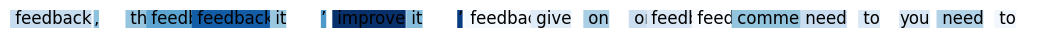

/var/folders/3g/2wscfy492xv8p55yn6b0rthw0000gn/T/ipykernel_63738/65976916.py:26: RuntimeWarning: invalid value encountered in divide
  norm_activations = (activations - np.min(activations)) / (np.max(activations) - np.min(activations))


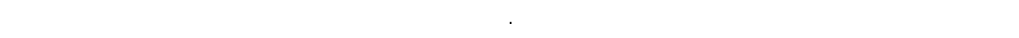

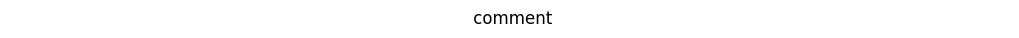

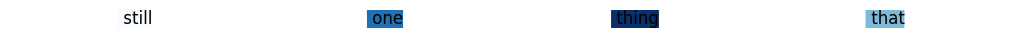

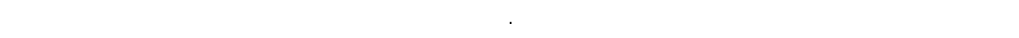

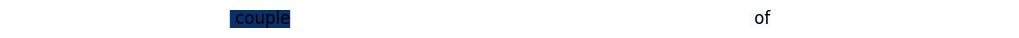

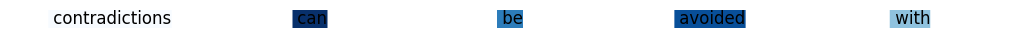

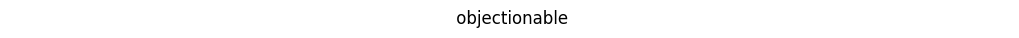

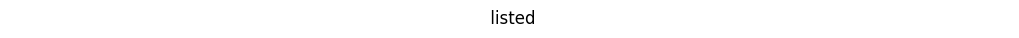

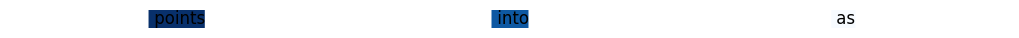

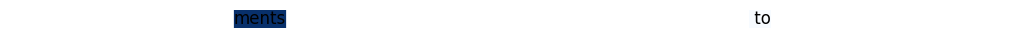

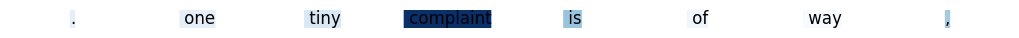

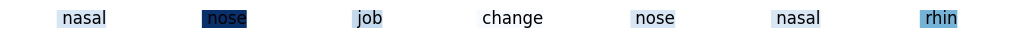

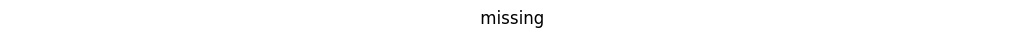

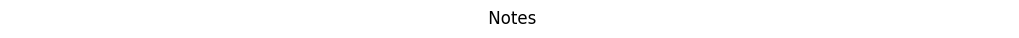

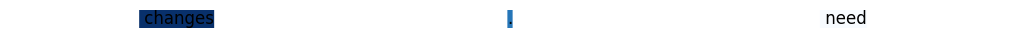

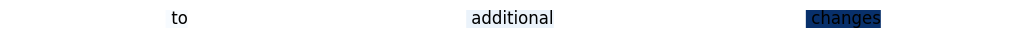

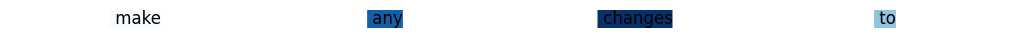

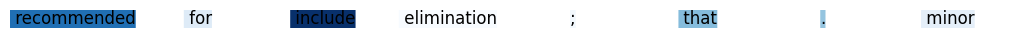

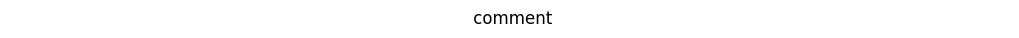

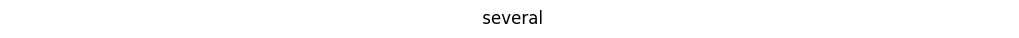

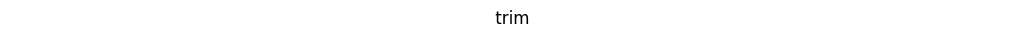

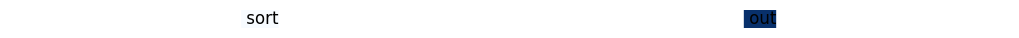

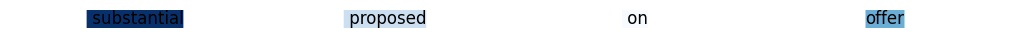

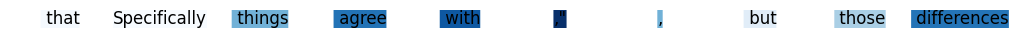

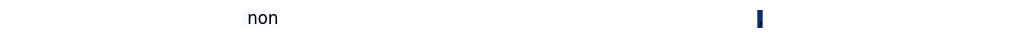

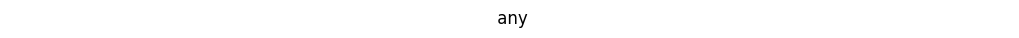

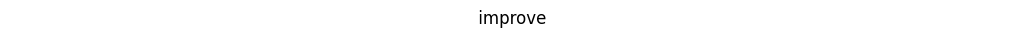

In [45]:
visualize_feature(2400, activations, locations)